In [2]:
import os
os.chdir(os.getcwd())

In [3]:
#limit VRAM usage
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)


2023-07-30 17:07:06.846687: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-30 17:07:06.967364: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-30 17:07:06.967535: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [4]:
#check and remove dodgy images from dataset
import cv2
import imghdr

data_dir = 'data'
image_exts = ['jpg', 'jpeg', 'bmp', 'png']
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print('Image extension not supported: ', format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('Issue with image: ', format(image_path))

In [5]:
#creating a dataset using keras and all the images in the data folder
import numpy as np
from matplotlib import pyplot as plt
#building a data pipeline
data = tf.keras.utils.image_dataset_from_directory('data')
validation = tf.keras.utils.image_dataset_from_directory('validation')
#scaling the data to be between 0 and 1 from 0 to 255
# logic - scaled = batch[0] / 255 but we apply this directly to the pipeline
data = data.map(lambda x, y: (x / 255, y)) # type: ignore
validation = validation.map(lambda x, y: (x / 255, y)) # type: ignore

Found 47009 files belonging to 2 classes.


2023-07-30 17:07:39.591914: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-30 17:07:39.592077: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-30 17:07:39.592202: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Found 11649 files belonging to 2 classes.


In [6]:
#making it an interator to allow us to loop through the data
data_iterator = data.as_numpy_iterator() # type: ignore
validation_iterator = validation.as_numpy_iterator() # type: ignore
#grab a batch of data
batch = data_iterator.next()
batch1 = validation_iterator.next()
#batch[0].shape #shape of the images
print(batch[1]) 
print(batch1[1])
# Classification labels: 0 - Female, 1 - Male.

2023-07-30 17:07:43.045355: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [47009]
	 [[{{node Placeholder/_4}}]]
2023-07-30 17:07:43.045661: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [47009]
	 [[{{node Placeholder/_4}}]]
2023-07-30 17:07:43.068180: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [11649

[0 0 0 1 0 1 0 0 0 1 0 1 1 1 0 1 0 1 1 0 0 1 0 0 0 1 0 1 0 1 1 0]
[1 1 1 1 0 1 0 1 1 0 1 1 0 1 0 0 0 1 1 0 1 0 0 0 0 0 1 1 1 0 1 1]


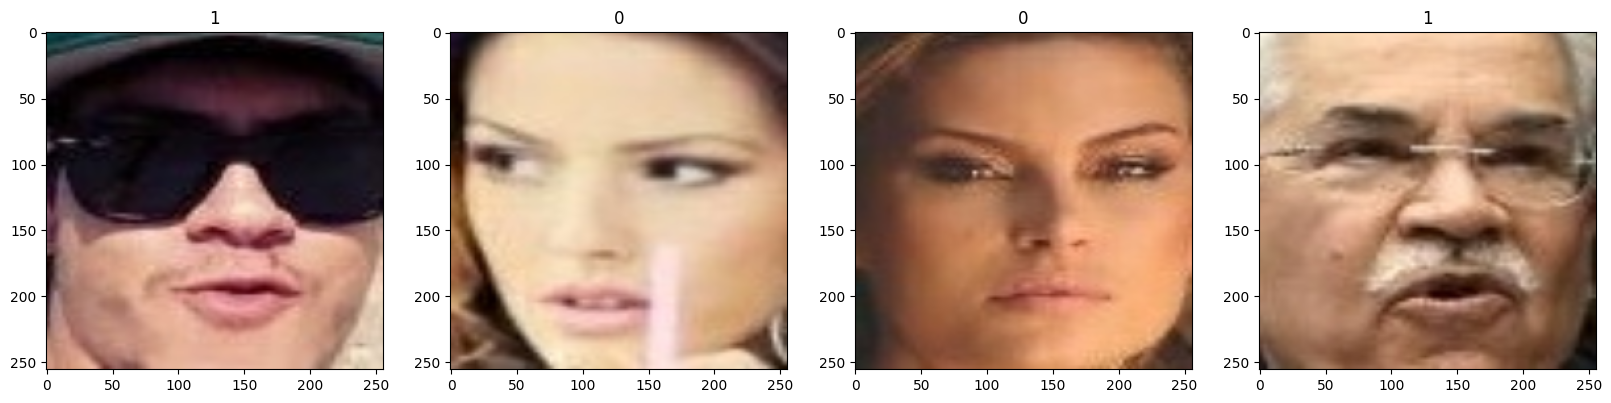

In [116]:
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    #ax[idx].imshow(img.astype(int))
    ax[idx].set_title(batch[1][idx])
    #ax[idx].title.set_text(batch[1][idx])

In [117]:
print('Data batches: ',len(data)) #number of batches of data
print('Validation data batches: ',len(validation)) #number of batches of validation data

Data batches:  1470
Validation data batches:  365


In [118]:
#making training, validation and test sets, they all add up to len(data) = 1470 in this case
train_size = len(data)
val_size = int(0.8 * len(validation))
test_size = int(0.2 * len(validation))
print(val_size)
train = data.take(train_size) # type: ignore
val = validation.take(val_size) # type: ignore
test = validation.skip(val_size).take(test_size) # type: ignore

292


In [119]:
#building the model
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D

model = Sequential()

model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256, 256, 3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 127, 127, 16)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 30, 30, 16)      

In [120]:
#training the model
logdir = 'logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
hist = model.fit(train, epochs=40, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/40


2023-07-26 18:13:36.107330: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [47009]
	 [[{{node Placeholder/_4}}]]
2023-07-26 18:13:36.107620: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [47009]
	 [[{{node Placeholder/_4}}]]


1468/1470 [============================>.] - ETA: 0s - loss: 0.2595 - accuracy: 0.8969

2023-07-26 18:13:59.224023: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [11649]
	 [[{{node Placeholder/_4}}]]
2023-07-26 18:13:59.224267: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [11649]
	 [[{{node Placeholder/_0}}]]


1470/1470 [==============================] - 26s 17ms/step - loss: 0.2595 - accuracy: 0.8969 - val_loss: 0.1887 - val_accuracy: 0.9283
Epoch 2/40
1470/1470 [==============================] - 25s 17ms/step - loss: 0.1684 - accuracy: 0.9365 - val_loss: 0.1695 - val_accuracy: 0.9351
Epoch 3/40
1470/1470 [==============================] - 24s 17ms/step - loss: 0.1305 - accuracy: 0.9515 - val_loss: 0.1348 - val_accuracy: 0.9504
Epoch 4/40
1470/1470 [==============================] - 24s 17ms/step - loss: 0.0981 - accuracy: 0.9642 - val_loss: 0.1398 - val_accuracy: 0.9496
Epoch 5/40
1470/1470 [==============================] - 24s 17ms/step - loss: 0.0702 - accuracy: 0.9746 - val_loss: 0.1849 - val_accuracy: 0.9439
Epoch 6/40
1470/1470 [==============================] - 24s 17ms/step - loss: 0.0483 - accuracy: 0.9822 - val_loss: 0.2128 - val_accuracy: 0.9485
Epoch 7/40
1470/1470 [==============================] - 24s 16ms/step - loss: 0.0342 - accuracy: 0.9876 - val_loss: 0.3106 - val_accura

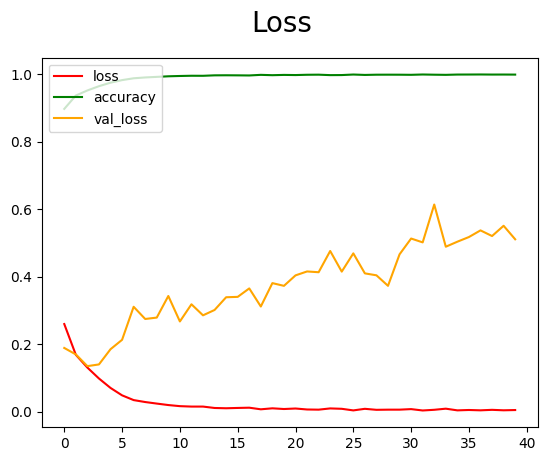

In [121]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='red', label='loss')
plt.plot(hist.history['accuracy'], color='green', label='accuracy')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

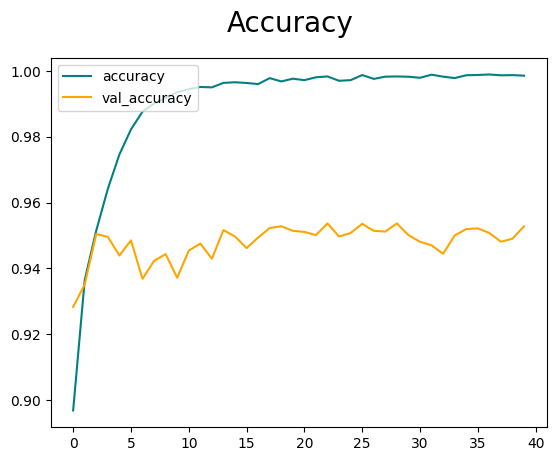

In [122]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [123]:
#Evaluate the model performance
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy # type: ignore
pre = Precision()
re = Recall()
acc = BinaryAccuracy()
len(test)

73

In [124]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

2023-07-26 18:29:48.455613: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [11649]
	 [[{{node Placeholder/_4}}]]
2023-07-26 18:29:48.456008: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [11649]
	 [[{{node Placeholder/_4}}]]


1/1 [==============================] - 0s 41ms/step


In [125]:
print(f'Precision: {pre.result().numpy()}, Recall: {re.result().numpy()}, Accuracy: {acc.result().numpy()}')

Precision: 0.9510309100151062, Recall: 0.948586106300354, Accuracy: 0.9492408037185669


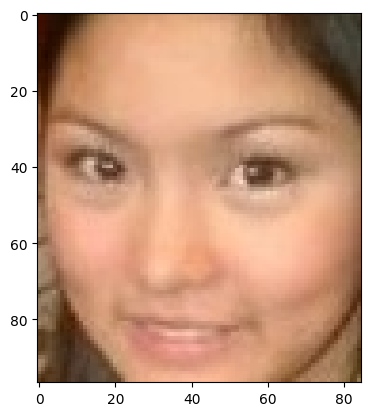

In [126]:
#Test the model
img = cv2.imread('ftest.jpg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

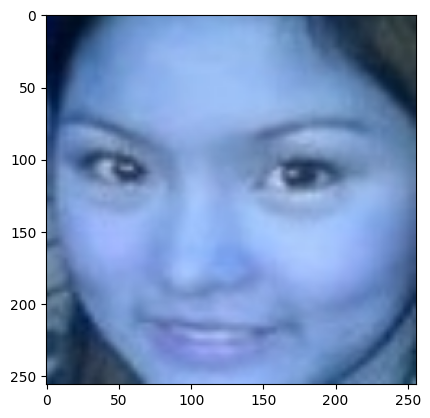

In [127]:
resize = tf.image.resize(img, (256, 256))
plt.imshow(resize.numpy().astype(int)) # type: ignore
plt.show()

In [128]:
np.expand_dims(resize, 0).shape
yhat = model.predict(np.expand_dims(resize/255, 0))
print(yhat)
if yhat>0.5:
    print('prediction: Male')
else:
    print('prediction: Female')

1/1 [==============================] - 0s 13ms/step
[[5.1434476e-08]]
prediction: Female


In [129]:
#Save the model for future use.
from tensorflow.keras.models import load_model
model.save(os.path.join('models','gender_classifier.h5'))

In [130]:
#Load the saved model
new_model = load_model(os.path.join('models','gender_classifier.h5'))
yhatnew = new_model.predict(np.expand_dims(resize/255, 0))
if yhat>0.5:
    print('prediction: Male')
else:
    print('prediction: Female')

1/1 [==============================] - 0s 40ms/step
prediction: Female


In [14]:
import aif360
import tensorflow as tf
import pandas as pd
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.algorithms.preprocessing import Reweighing
from sklearn.metrics import accuracy_score

# Load your data as a tf.data.Dataset object
mydata = tf.keras.utils.image_dataset_from_directory('data')

# Convert the tf.data.Dataset object to a pandas DataFrame object
data = pd.DataFrame(columns = ['features', 'gender'])
for features, labels in mydata:
    data = pd.concat([data, pd.DataFrame({'features': [features.numpy()], 'gender': [labels.numpy()]})], ignore_index=True)

# Convert the pandas DataFrame object to a BinaryLabelDataset object
data = BinaryLabelDataset(df = data, label_names = ['gender'], 
                          favorable_label = 1, unfavorable_label = 0)

# Split your data into train and test sets
train_data, test_data = data.split([0.7], shuffle = True)

# Define the privileged and unprivileged groups based on the label
# For example, if you want to compare male and female groups
privileged_groups = [{'gender': 1}] # male
unprivileged_groups = [{'gender': 0}] # female

# Compute the mean difference metric on the train data
metric_train = BinaryLabelDatasetMetric(train_data, privileged_groups = privileged_groups,
                                        unprivileged_groups = unprivileged_groups)
mean_difference_train = metric_train.mean_difference()
print("Mean difference on train data: ", mean_difference_train)

# Compute the mean difference metric on the test data
metric_test = BinaryLabelDatasetMetric(test_data, privileged_groups = privileged_groups,
                                       unprivileged_groups = unprivileged_groups)
mean_difference_test = metric_test.mean_difference()
print("Mean difference on test data: ", mean_difference_test)

# Apply a pre-processing technique to mitigate bias in the train data
# For example, use Reweighing algorithm
# Reweighing assigns weights to each sample in the training set such that the distributions of the outcomes in the privileged and unprivileged groups are similar
RW = Reweighing()
RW.fit(train_data, privileged_groups = privileged_groups, unprivileged_groups = unprivileged_groups)
train_data_transformed = RW.transform(train_data)

# Compute the mean difference metric on the transformed train data
metric_train_transformed = BinaryLabelDatasetMetric(train_data_transformed, privileged_groups = privileged_groups,
                                                    unprivileged_groups = unprivileged_groups)
mean_difference_train_transformed = metric_train_transformed.mean_difference()
print("Mean difference on transformed train data: ", mean_difference_train_transformed)

# Train your gender classifier on the transformed train data
# For example, use a logistic regression model from sklearn
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
X_train = train_data_transformed.features # feature matrix
y_train = train_data_transformed.labels # label vector
model.fit(X_train, y_train)

# Make predictions on the test data using your gender classifier
X_test = test_data.features # feature matrix
y_test = test_data.labels # label vector
y_pred = model.predict(X_test) # predicted labels

# Evaluate the accuracy of your gender classifier on the test data
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy of gender classifier on test data: ", accuracy)


Found 47009 files belonging to 2 classes.


2023-07-30 17:39:35.002003: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [47009]
	 [[{{node Placeholder/_4}}]]
2023-07-30 17:39:35.002267: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [47009]
	 [[{{node Placeholder/_0}}]]
